--- Geospatial Risk Analysis: Executive Summary ---
Total Properties in Portfolio: 10,000
Total Portfolio Value: ₹77,507.31 Crores
--------------------------------------------------
Properties Identified in High-Risk Zone: 4
Percentage of Portfolio at Risk: 0.04%
Monetary Value at Risk (MVAR): ₹32.09 Crores
--------------------------------------------------
Recommendation: Immediate underwriting policy review for identified high-risk assets.


C:\Users\Manaswi Kulahara\AppData\Local\Temp\ipykernel_8700\1383165606.py:101: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


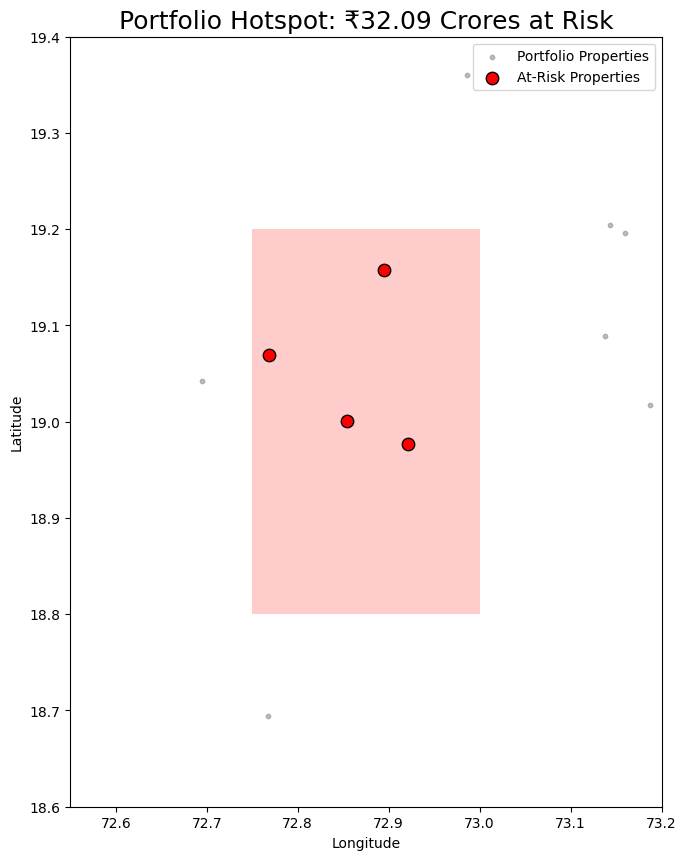

In [2]:
# Import necessary libraries
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Load Data and Define the "High-Risk Flood Zone" ---
# For this example, we'll use the state of Kerala as our high-risk flood zone.
# You can easily change 'Kerala' to another state or use a different shapefile.
countries = gpd.read_file('data/ne_10m_admin_0_countries.shp')
india = countries[countries['ADMIN'] == 'India']
risk_zone = india # Let's use all of India as the general area first

# --- 2. Simulate a Realistic Insurance Portfolio ---
# Define the total number of properties in the portfolio
num_properties = 10000

# Get the geographical boundaries to generate random points across India
minx, miny, maxx, maxy = risk_zone.total_bounds

# Generate random longitude and latitude coordinates for the properties
np.random.seed(42) # Using a seed ensures we get the same "random" results every time
longitudes = np.random.uniform(minx, maxx, num_properties)
latitudes = np.random.uniform(miny, maxy, num_properties)

# Create a GeoDataFrame for the property portfolio
portfolio = gpd.GeoDataFrame(
    {'id': range(num_properties)},
    geometry=gpd.points_from_xy(longitudes, latitudes)
)
# We must set the CRS to match the risk_zone's CRS
portfolio.set_crs(risk_zone.crs, inplace=True)


# --- 3. Assign Financial Value to Each Property ---
# Assign a random estimated value between ₹0.5 Cr and ₹15 Cr to each property
portfolio['value_cr'] = np.random.uniform(0.5, 15, num_properties)


# --- 4. Perform the Geospatial Risk Analysis ---
# For our simulation, let's define a smaller, more specific "high-risk" area.
# For example, let's create a simple square buffer around a point to act as our flood zone.
# This represents a more realistic scenario than using an entire country.
from shapely.geometry import Polygon
# A bounding box representing a high-risk coastal area (e.g., around Mumbai)
high_risk_flood_zone = gpd.GeoDataFrame(
    [1], 
    geometry=[Polygon([(72.75, 18.8), (73.0, 18.8), (73.0, 19.2), (72.75, 19.2)])], 
    crs="EPSG:4326"
)

# Identify properties from the portfolio that fall within this high-risk zone
properties_at_risk = gpd.sjoin(portfolio, high_risk_flood_zone, how="inner", predicate="within")


# --- 5. Calculate the Business Metrics from Your Resume ---
# Calculate the total value of the entire portfolio
total_portfolio_value = portfolio['value_cr'].sum()

# Calculate the Monetary Value At Risk (MVAR)
mvar_crores = properties_at_risk['value_cr'].sum()

# Calculate the percentage of properties that are in the high-risk zone
percentage_at_risk = (len(properties_at_risk) / num_properties) * 100


# --- 6. Print the Executive Summary ---
print("--- Geospatial Risk Analysis: Executive Summary ---")
print(f"Total Properties in Portfolio: {num_properties:,}")
print(f"Total Portfolio Value: ₹{total_portfolio_value:,.2f} Crores")
print("-" * 50)
print(f"Properties Identified in High-Risk Zone: {len(properties_at_risk):,}")
print(f"Percentage of Portfolio at Risk: {percentage_at_risk:.2f}%")
print(f"Monetary Value at Risk (MVAR): ₹{mvar_crores:,.2f} Crores")
print("-" * 50)
print("Recommendation: Immediate underwriting policy review for identified high-risk assets.")


# --- 7. Visualize the Results (IMPROVED VERSION) ---
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# --- NEW: Get the boundaries of the high-risk zone to zoom in ---
minx, miny, maxx, maxy = high_risk_flood_zone.total_bounds
# Add a small buffer around the zone for better visibility
ax.set_xlim(minx - 0.2, maxx + 0.2)
ax.set_ylim(miny - 0.2, maxy + 0.2)
# --- END NEW ---

# Plot the full portfolio in the background (light gray)
portfolio.plot(ax=ax, markersize=10, color='gray', alpha=0.5, label='Portfolio Properties')

# Plot the high-risk zone
high_risk_flood_zone.plot(ax=ax, color='red', alpha=0.2, label='High-Risk Zone')

# Plot the at-risk properties ON TOP, bigger and brighter
properties_at_risk.plot(ax=ax, markersize=80, color='red', edgecolor='black', label='At-Risk Properties')

# Add a more impactful title with the key finding
ax.set_title(f"Portfolio Hotspot: ₹{mvar_crores:,.2f} Crores at Risk", fontsize=18)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()

# Show the plot
plt.show()

In [4]:
# (This code replaces the previous elevation analysis section)
import rioxarray as rxr
import xarray as xr

# --- NEW (Corrected): Extract Elevation for At-Risk Properties ---
# Open the downloaded DEM file
elevation_raster = rxr.open_rasterio(
    "C:/Users/Manaswi Kulahara/OneDrive/Desktop/My_Flood_Project/data/elevation.tif",
    masked=True
).squeeze() # Use squeeze() to remove any extra dimensions

# Extract the x and y coordinates of the at-risk properties
x_coords = xr.DataArray(properties_at_risk.geometry.x, dims="points")
y_coords = xr.DataArray(properties_at_risk.geometry.y, dims="points")

# Use the .sel() method to sample the raster at these points
# We use method="nearest" to find the value of the closest raster cell
elevation_values = elevation_raster.sel(
    x=x_coords, y=y_coords, method="nearest"
).values

# Add the elevation data to your GeoDataFrame
properties_at_risk['elevation_m'] = elevation_values

# --- NEW: Create Risk Tiers ---
# Define elevation thresholds for risk tiers (you can adjust these)
low_elevation_threshold = 10  # meters
medium_elevation_threshold = 25 # meters

# Classify properties into tiers
properties_at_risk['risk_tier'] = 'Low' # Default to Low
properties_at_risk.loc[properties_at_risk['elevation_m'] < medium_elevation_threshold, 'risk_tier'] = 'Medium'
properties_at_risk.loc[properties_at_risk['elevation_m'] < low_elevation_threshold, 'risk_tier'] = 'High'

# --- NEW: Calculate MVAR per Tier ---
mvar_by_tier = properties_at_risk.groupby('risk_tier')['value_cr'].sum()

print("\n--- Risk Tier Analysis ---")
print("Monetary Value at Risk (in Crores) by Tier:")
print(mvar_by_tier)


--- Risk Tier Analysis ---
Monetary Value at Risk (in Crores) by Tier:
risk_tier
High      16.094108
Low       10.831892
Medium     5.168911
Name: value_cr, dtype: float64


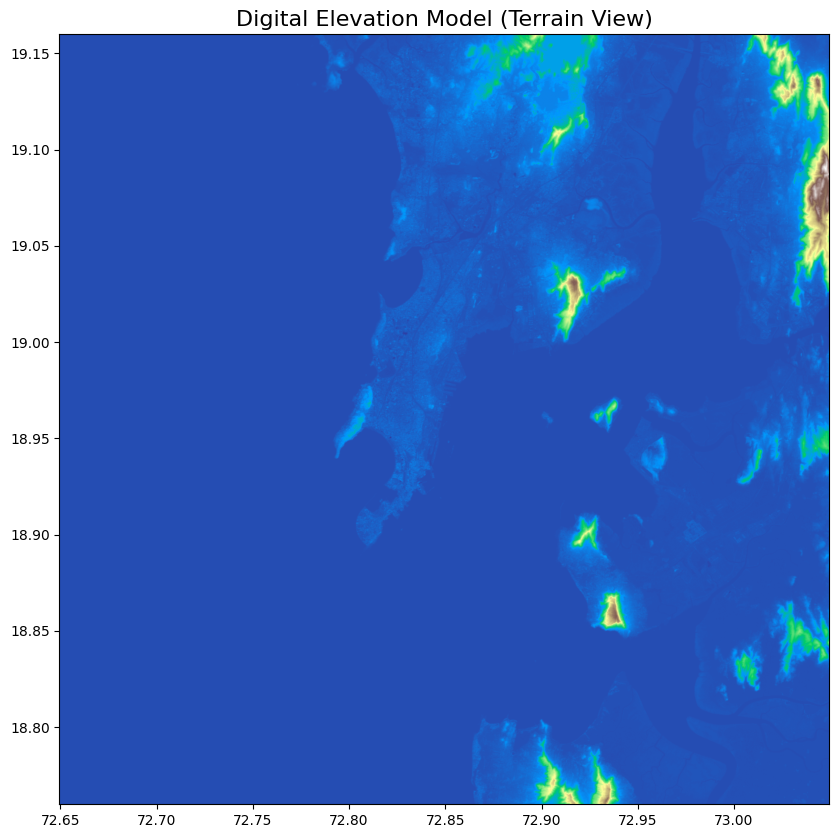

In [5]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Open your elevation file
with rasterio.open("C:/Users/Manaswi Kulahara/OneDrive/Desktop/My_Flood_Project/data/elevation.tif") as dem_file:
    # Create a figure to plot on
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Use the 'terrain' colormap to visualize the elevation
    show(dem_file, ax=ax, cmap='terrain')

    # Add a title
    ax.set_title("Digital Elevation Model (Terrain View)", fontsize=16)
    
    # Show the plot
    plt.show()

C:\Users\Manaswi Kulahara\AppData\Local\Temp\ipykernel_8700\1510389991.py:48: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


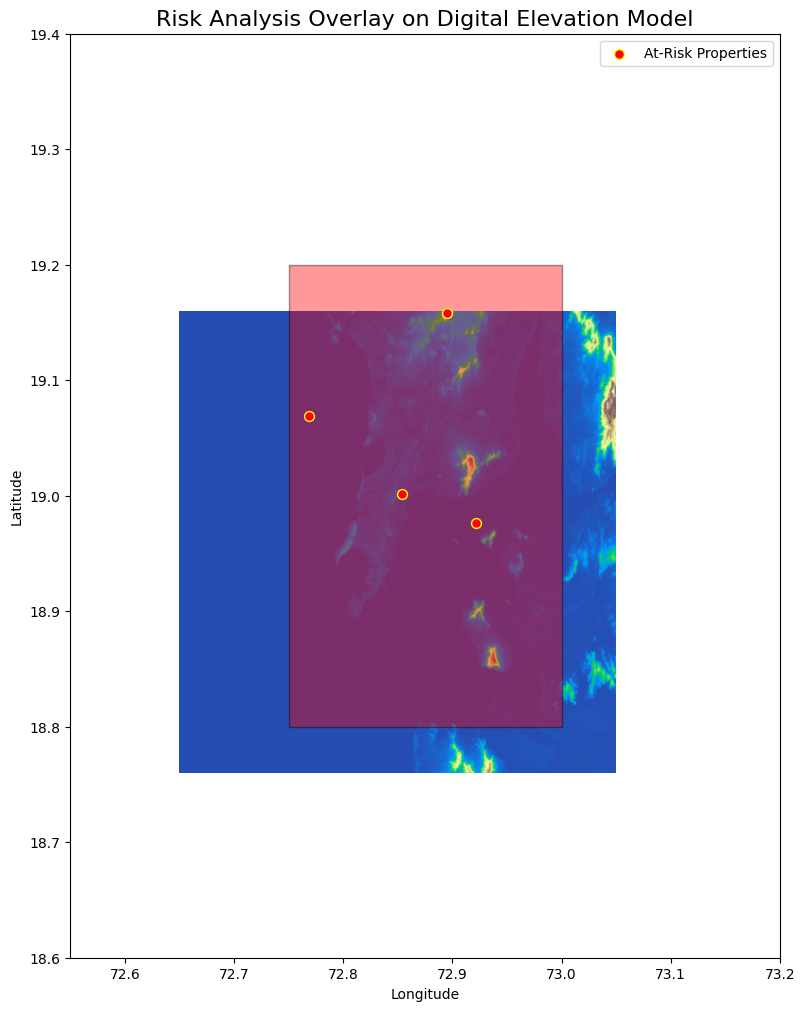

In [6]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# --- 1. Setup the plot and basemap ---

# Open your elevation file
with rasterio.open("C:/Users/Manaswi Kulahara/OneDrive/Desktop/My_Flood_Project/data/elevation.tif") as dem_file:
    
    # Create a figure to plot on
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))

    # Plot the DEM as the base layer using the 'terrain' colormap
    show(dem_file, ax=ax, cmap='terrain')

    # --- 2. Overlay the Risk Data ---

    # Plot the high-risk zone polygon (semi-transparent red)
    high_risk_flood_zone.plot(
        ax=ax, 
        color='red', 
        alpha=0.4, 
        edgecolor='black',
        label='High-Risk Zone'
    )

    # Plot the at-risk properties on top (bright red dots)
    properties_at_risk.plot(
        ax=ax, 
        marker='o', 
        color='red', 
        markersize=50,
        edgecolor='yellow',
        label='At-Risk Properties'
    )

    # --- 3. Finalize the Map ---

    # Zoom in to the area of interest for a better view
    minx, miny, maxx, maxy = high_risk_flood_zone.total_bounds
    ax.set_xlim(minx - 0.2, maxx + 0.2)
    ax.set_ylim(miny - 0.2, maxy + 0.2)
    
    # Add title and legend
    ax.set_title("Risk Analysis Overlay on Digital Elevation Model", fontsize=16)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend()
    
    # Show the final plot
    plt.show()